## Building a Fires analysis

In order to give the recent [Sumi Viirs](https://jointmission.gsfc.nasa.gov/viirs.html) data context, we will need to characterise the 'normal' conditions over given areas and times (i.e. seasonal conditions).

To do this we will need to obtain long-term (historical) data - these can be downloaded from [NASA FIRMS](https://firms.modaps.eosdis.nasa.gov/) site. Follow the link to the **Archive Download tool** and select data **New Request** for the **VIIRS 375 m** data (which more specifically come from the [VNP14IMGTDL_NRT](https://earthdata.nasa.gov/earth-observation-data/near-real-time/firms/v1-vnp14imgt) dataset). Select the entire globe (you can do this by roughly drawing a polygon around the worlds land areas), and select the largest date period possible. 
You can request these data as a CSV file (a download link will be sent to a specified email address when the data are prepared).

The meanining of the file attributes is explained [here](https://earthdata.nasa.gov/earth-observation-data/near-real-time/firms/v1-vnp14imgt).

Once the data file are obtained we can process them in the following manner:

In [1]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
fires = pd.read_csv('/Users/Ben/Downloads/fire_nrt_V1_16669.csv')

In [3]:
fires.head()

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight
0,-23.615,-55.508,340.6,0.7,0.8,2016-01-28,1820,N,VIIRS,n,1.0,287.0,0.0,D
1,-15.411,-60.182,332.3,0.5,0.7,2016-01-28,1820,N,VIIRS,n,1.0,282.1,0.0,D
2,-15.412,-60.187,329.7,0.5,0.7,2016-01-28,1820,N,VIIRS,n,1.0,281.8,0.0,D
3,-13.997,-59.910,333.8,0.6,0.7,2016-01-28,1820,N,VIIRS,n,1.0,273.0,0.0,D
4,-13.998,-59.909,337.5,0.6,0.7,2016-01-28,1820,N,VIIRS,n,1.0,273.0,0.0,D


In [4]:
print(f'{len(fires):,} rows of data in file')

1,662,059 rows of data in file


We are interested in the high confidence, day-time retrievals.

Confidence values are set to low (l), nominal (n) and high (h). Low confidence daytime fire pixels are typically associated with areas of sun glint and lower relative temperature anomaly (<15K) in the mid-infrared channel I4. Nominal confidence pixels are those free of potential sun glint contamination during the day and marked by strong (>15K) temperature anomaly in either day or nighttime data. High confidence fire pixels are associated with day or nighttime saturated pixels

In [5]:
# Let's remove the low quality and nighttime retrevials

#print(fires['confidence'].unique())
print(f"{len(fires[fires['confidence']=='l'])/len(fires) * 100 :3.2f} % of detections were Low Quality")

if len(fires[fires['confidence']=='l'])> 0:
    print("Removing Low Quality detections")
    fires = fires[fires['confidence']!='l']
    
#fires['daynight'].unique()  # We can see D and N values in daynight to indicate day and night
print(f"{len(fires[fires['daynight'] == 'N'])/len(fires) * 100 :3.2f} % of fires were detected during Nighttime")
fires = fires[fires['daynight'] == 'D']

print('Fires data cleaned.')

8.10 % of detections were Low Quality
Removing Low Quality detections
31.34 % of fires were detected during Nighttime
Fires data cleaned.


Now we parse the dates to generate a date index (out of dt objects) so we can resample the dataset, and we also add a count which will be useful to calculate a sum when we change the temporal sampling to weekly.

In [12]:
dtstrings = fires['acq_date'].values
dates = [pd.datetime(int(dt.split('-')[0]),int(dt.split('-')[1]),int(dt.split('-')[2])) for dt in dtstrings]
counts = [1] * len(fires)
fires.index = dates
fires['counts'] = counts

In [14]:
fires.head()

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,date_obj,counts
2016-01-28,-23.615,-55.508,340.6,0.7,0.8,2016-01-28,1820,N,VIIRS,n,1.0,287.0,0.0,D,2016-01-28,1
2016-01-28,-15.411,-60.182,332.3,0.5,0.7,2016-01-28,1820,N,VIIRS,n,1.0,282.1,0.0,D,2016-01-28,1
2016-01-28,-15.412,-60.187,329.7,0.5,0.7,2016-01-28,1820,N,VIIRS,n,1.0,281.8,0.0,D,2016-01-28,1
2016-01-28,-13.997,-59.910,333.8,0.6,0.7,2016-01-28,1820,N,VIIRS,n,1.0,273.0,0.0,D,2016-01-28,1
2016-01-28,-13.998,-59.909,337.5,0.6,0.7,2016-01-28,1820,N,VIIRS,n,1.0,273.0,0.0,D,2016-01-28,1


At this point we create a geopandas series out of the lat, long data.

In [53]:
%%time
# with ~1 million points this will take something around 15 seconds
points = [Point(pair) for pair in zip(fires['latitude'].values, fires['longitude'])]

CPU times: user 14.6 s, sys: 451 ms, total: 15 s
Wall time: 15.1 s


In [58]:
gdf = gpd.GeoDataFrame(fires, geometry=points, crs={'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

In [60]:
gdf.head()

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight,date_obj,counts,geometry
2016-01-28,-23.615,-55.508,340.6,0.7,0.8,2016-01-28,1820,N,VIIRS,n,1.0,287.0,0.0,D,2016-01-28,1,POINT (-23.615 -55.508)
2016-01-28,-15.411,-60.182,332.3,0.5,0.7,2016-01-28,1820,N,VIIRS,n,1.0,282.1,0.0,D,2016-01-28,1,POINT (-15.411 -60.182)
2016-01-28,-15.412,-60.187,329.7,0.5,0.7,2016-01-28,1820,N,VIIRS,n,1.0,281.8,0.0,D,2016-01-28,1,POINT (-15.412 -60.187)
2016-01-28,-13.997,-59.910,333.8,0.6,0.7,2016-01-28,1820,N,VIIRS,n,1.0,273.0,0.0,D,2016-01-28,1,POINT (-13.997 -59.91)
2016-01-28,-13.998,-59.909,337.5,0.6,0.7,2016-01-28,1820,N,VIIRS,n,1.0,273.0,0.0,D,2016-01-28,1,POINT (-13.998 -59.909)


## Next step:

Here we need to identify the points that correspond to a shape of interest (e.g. country polygon)

In [ ]:
### CODE HERE TO ISCOLATE SUBSET OF DATAFRAME BY COUNTRY OR AOI

Next we resample these data to Weekly values

In [69]:
weekly_sum = gdf['counts'].resample('W').sum() #fires['counts'].resample('D').sum().interpolate()[::7]

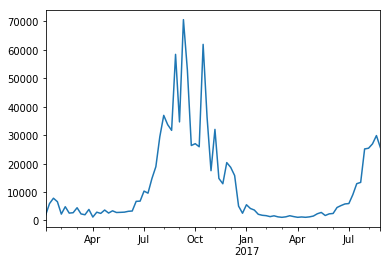

In [17]:
weekly_sum.plot()

Now we have a time series of counts, we will need to calculate the week of year mean, and standard deviations.
Finally, these statistics are what we will plot to know the climatological normal conditions.

## Next step:

In [ ]:
## CODE to caclualte Week of year Mean and Standard deviation over an area of interest.